# Optimal Growth IV: The Stochastic Optimal Growth Model

## Endogenous grid method

Based on the QuantEcon lecture https://python.quantecon.org/egm_policy_iter.html

In [ ]:
!pip install --upgrade quantecon
!pip install interpolation

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from interpolation import interp
#from numba import jit, njit, jitclass, prange, float64, int32
from numba import jit, njit, prange, float64, int32
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max
from quantecon.optimize import brentq

%matplotlib inline

### Neoclassical Growth Model

Recursive formulation of the planner problem:
\begin{align*}
v(k, \xi) &= \max_{c,k} \left\{ u(c) + \beta E[v(k', \xi')] \right\} \\
    &c + (k' - (1-\delta) k) = \xi \ f(k) \\
    &\xi, \xi' \sim_{iid} \phi
\end{align*}

Since the shocks are iid, we do not need to keep track of the shock realization; the shock only matters in determining the current value of output. Suppose further that there is full depreciation (that is, $\delta = 1$). We no longer need to keep track of the capital stock. We can then drop the state variable $\xi$ and reexpress the problem in terms of output as follows:
\begin{align*}
v(y) &= \max_c \left\{ u(c) + \beta E[v(y')] \right\} \\
    y' &= \xi \ f(y - c) \\
    \xi &\sim \phi
\end{align*}

Parametrization of the problem
\begin{align*}
\delta &=1 \\
u(c) &= \ln(c) \\
f(k) &= k^\alpha \\
\phi(\xi) &= \exp(\mu + s \zeta) \ \text{where} \ \zeta \sim N(0,1)
\end{align*}

## Exogenous grid method

#### Time Iterations: Euler equation method

Instead of iterating on the value function, we iteration on the Euler equation. The notes on QuantEcon show the equivalence of these two methods in theory. In practice, however, Euler equation method is can be faster since the approximation of the policy function is easier.

For every $y$, the policy function $c = c(y)$ solves the Euler equation:
\begin{equation*}
u'(c) = \beta \int \ v'(f(y - c) z) \ f'(y - c) z \phi dz
\end{equation*}

By the envelope condition:
\begin{equation*}
v'(y) = \beta \int \ v'(f(y - c) z) \ f'(y - c) z \phi dz = u'(c(y)) = (u' \circ c)(y)
\end{equation*}

Substituting the envelope condition into the Euler equation allows to write the policy as a fixed point of a functional equation:
\begin{equation*}
u'(c(y)) = \beta \int \ (u' \circ c)(f(y - c(y)) z) \ f'(y - c(y)) z \phi dz
\end{equation*}

##### Mapping from guess $c_\tau$ to updated guess $c_{\tau+1}$, that is there is an operator $K$ for which $c_{\tau + 1} = K(c_\tau)$ where $K$ is the Coleman-Reffett operator

for every $y$, the updated policy is $c_{\tau+1}(y)$ which solves:
\begin{equation*}
u'(c) = \beta \int \ (u' \circ c_\tau)(f(y - c) z) \ f'(y - c) z \phi dz
\end{equation*}
That is, for all $y$:
\begin{equation*}
u'(c_{\tau+1}(y)) = \beta \int \ (u' \circ c_\tau)(f(y - c_{\tau+1}(y)) z) \ f'(y - c_{\tau+1}(y)) z \phi dz
\end{equation*}

Note that finding the root in the Time Iteration (Euler equation) is computationally burdensome. The endogenous grid method bypasses the step of finding a root.

## Endogenous grid method

##### Mapping from guess $c_\tau$ to updated guess $c_{\tau+1}$, that is there is an operator Endogenous grid 
It is best to think of a policy as a pair (grid on $y_\tau, c_\tau$) where $c_\tau$ is a vector of consumption associated with each $y_\tau$ in the grid. Construct a grid for $k$ as follows:
\begin{equation*}
k_{\tau}(y_{\tau}) = y_\tau - c_\tau(y_\tau)
\end{equation*}

For every $y_\tau$, find the updated policy is $c_{\tau+1}(y_\tau)$ which is:
\begin{equation*}
c_{\tau+1}(y_\tau) = (u')^{-1}(\beta \int \ (u' \circ c_\tau)(f(k_\tau(y_{\tau})) z) \ f'(k_\tau(y_{\tau})) z \phi dz)
\end{equation*}
Construct a new grid for $y$:
\begin{equation*}
y_{\tau + 1} = k_{\tau}(y_\tau) + c_{\tau + 1}(y_\tau)
\end{equation*}
We can now iterate starting with the pair $(y_{\tau+1}, c_{\tau +1})$

#### Implementation of the algorithm

1. Numba: to use numba JIT which makes the code fast, we specifiy the types of the data
2. Build class for the model including 
    1. a function that updates the policy for a given grid
    2. a function that updates the grid for a given pair (grid, policy)
3. Iterate on policy function and grid

In [2]:
'This is to be able to use JIT from Numba to speed up the code, which will be done with at jitclass before the class'
opt_growth_data = [
    ('alpha', float64), # power of production function
    ('beta', float64), # discount factor
    ('mu', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

In [26]:
@jitclass(opt_growth_data) #jitclass because we are building a class
class QE_OptimalGrowth():
    def __init__(self,
                alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250):
        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 
        self.grid = np.linspace(1e-5, grid_max, grid_size) # set up the grid for the state y
        self.shocks = np.exp(mu + s * np.random.randn(shock_size)) # draw some shocks to take expectations
    
    def f(self, k):
        return k**self.alpha
    
    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)
    
    def u(self, c):
        return np.log(c)
    
    def u_prime(self, c):
        return 1/c
    
    def u_prime_inverse(self, c):
        return 1/c
    
    def RHS_Bellman(self, c, y, v_array):
        'returns the right hand side for a given choice c and a given state y'
        u, f, beta, shocks = self.u, self.f, self.beta, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c) + beta * np.mean(v(f(y-c) * shocks)) #np.mean computes the expectation over shock_size draws

    def RHS_ColemanReffett(self, c, y, c_array):
        'returns the right hand side for a given choice c and a given state y'
        pol = lambda x: interp(self.grid, c_array, x)
        return self.u_prime(c) - self.beta * np.mean(self.u_prime(pol(self.f(y - c) * self.shocks)) * self.f_prime(y - c) * self.shocks)
    
    def RHS_Endogenous_grid(self, grid, c_array):
        'returns the updated policy array'
        c_new = np.empty_like(c_array)
        k = grid - c_array # creates a grid for k
        print(k)
        assert min(k) >= 0, "k = grid - c_array in RHS_Endogenous_grid must be nonnegative"
        policy = lambda x: interp(grid, c_array, x) 
        for i in range(len(c_array)):
            c_new[i] = self.u_prime_inverse(self.beta * np.mean(self.u_prime(policy(self.f(k[i]) * self.shocks)) * self.f_prime(k[i]) * self.shocks))
        return c_new 
        
    def Update_grid(self, grid, c_array, c_update):
        '''
        k = grid - c_array
        y = k + c_update '''
        return grid - c_array + c_update

#### Create an instance

In [27]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 4,
                grid_size = 200,
                shock_size = 250)

#### Exact solution

In [10]:
def Exact_policy(og, y):
    """
    True optimal policy
    """
    return (1 - og.alpha * og.beta) * y

def Exact_v(og, y):
    """
    True value function
    """
    c1 = np.log(1 - og.alpha * og.beta) / (1 - og.beta)
    c2 = (og.mu + og.alpha * np.log(og.alpha * og.beta)) / (1 - og.alpha)
    c3 = 1 / (1 - og.beta)
    c4 = 1 / (1 - og.alpha * og.beta)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

### Time Iteration: Endogenous grid method

In [23]:
def Endogenous_grid(og,
                    c_array, 
                    tol = 1e-5,
                    max_iter = 50,
                    verbose = True,
                    print_skip = 5):
    ''' 
    og is an instance of the class QE_OptimalGrowth
    c_array is our initial guess of policy function
    tol is the tolerance below which we claim convergence
    '''
    i = 0
    error = tol + 1
    
    c_new = c_array # creates a vector of the same size as c_array that will record c' 
    grid_new = og.grid
    
    while i < max_iter and error > tol:
        c_new_new = og.RHS_Endogenous_grid(grid_new, c_new)
        error = np.max(np.abs(c_new_new - c_new))
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        i += 1
        grid_new = og.Update_grid(grid_new, c_new, c_new_new)
        c_new = c_new_new
    
    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    #return c_new        
    return grid_new, c_new        

Error at iteration 0 is nan.

Converged in 1 iterations.


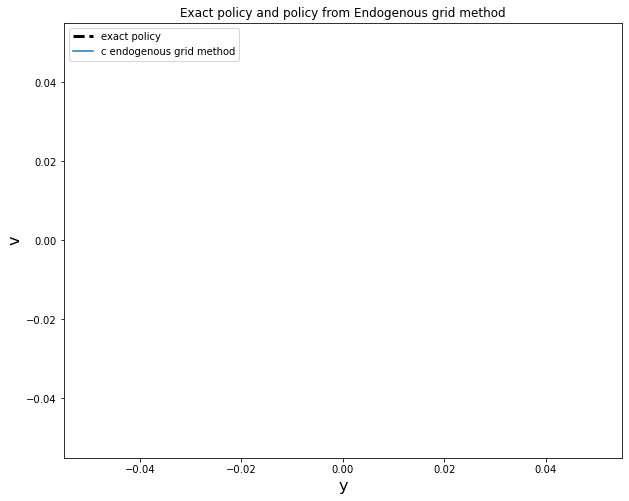

In [25]:
c_array = 3 * og.grid # initial guess

[grid, c_star] = Endogenous_grid(og, c_array)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = grid
ax.plot(xgrid, Exact_policy(og, xgrid), 'k--', lw=3, label='exact policy')
ax.plot(xgrid, c_star, label='c endogenous grid method')
ax.set_title('Exact policy and policy from Endogenous grid method') 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('v', fontsize=16)
ax.legend(loc='upper left')
plt.show()

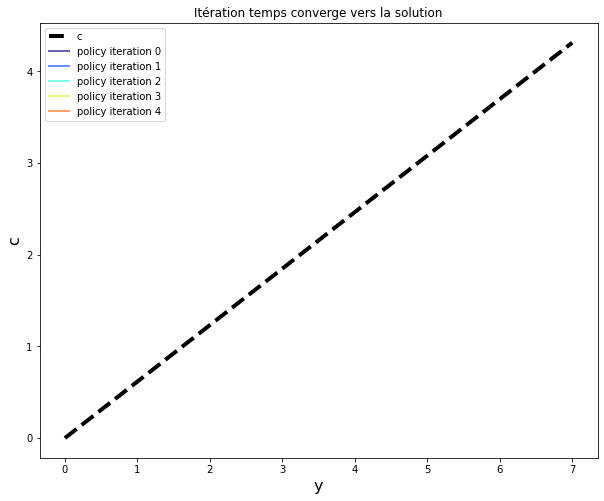

In [16]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 7,
                grid_size = 200,
                shock_size = 250)

fig, ax = plt.subplots(figsize=(10,8))
xgrid = og.grid
ax.plot(xgrid, Exact_policy(og, xgrid), 'k--', lw =4 , label='c')
c_new = 3 * og.grid
grid_new= og.grid
num_iter = 5
for i in range(num_iter):
    c_new_new = og.RHS_Endogenous_grid(grid_new, c_new)
    grid_new = og.Update_grid(grid_new, c_new, c_new_new)
    c_new = c_new_new
    ax.plot(grid_new, c_new, color=plt.cm.jet(i / num_iter), lw=2, alpha=0.6, label='policy iteration %s' %i)
ax.set_title('Itération temps converge vers la solution') 
ax.set_xlabel('y', fontsize=16)
ax.set_ylabel('c', fontsize=16)
ax.legend(loc='upper left')
save_results_to = '/Users/guillaumesublet/Dropbox/Economics/Teaching/Montreal/ECN_7055/I_Marches_complets/Cours2_Methodes_Numeriques/'
plt.savefig(save_results_to + 'ECN7055_EndogenousGrid.pdf', dpi = 300)
plt.show()

### Running time of functions

In [17]:
og = QE_OptimalGrowth(alpha = 0.4,
                beta= 0.96,
                mu = 0,
                s = 0.1,
                grid_max = 7,
                grid_size = 200,
                shock_size = 250)

c_array = 3 * og.grid
v = 3 * np.log(og.grid)
c= 0.05
y = 1

%timeit og.RHS_Endogenous_grid(og.grid, c_array)
%timeit og.RHS_Bellman(c, y, v)
%timeit og.RHS_ColemanReffett(c, y, c_array)

2.33 ms ± 44.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.1 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.4 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
